In [1]:
import os
import cv2
import imageio
import numpy as np
from multiprocessing import Pool
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, TimeDistributed, GlobalAveragePooling2D, Dense, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
import matplotlib.pyplot as plt



In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Path to the dataset in your Google Drive
dataset_path = '/content/drive/My Drive/HAR'

In [4]:
def generate_frame_data(video_path, target_size=(224, 224), num_frames=10, frame_skip=5):
    frames = []
    cap = cv2.VideoCapture(video_path)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for frame_num in range(0, total_frames, frame_skip):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.resize(frame, target_size)
        frames.append(frame)

        if len(frames) == num_frames:
            break

    cap.release()
    return frames


In [5]:
def data_generator(video_paths, labels, target_size=(224, 224), num_frames=10, frame_skip=5, batch_size=32):
    while True:
        indices = np.random.choice(len(video_paths), batch_size, replace=False)
        frames_batch = []
        labels_batch = []

        for index in indices:
            video_path = video_paths[index]
            label = labels[index]

            frames = generate_frame_data(video_path, target_size, num_frames, frame_skip)
            frames = np.array(frames)
            label = np.array([1 if l == 'Violence' else 0 for l in label])

            frames_batch.append(frames)
            labels_batch.append(label)

        yield np.array(frames_batch), np.array(labels_batch)


In [6]:
# List of video paths and corresponding labels
video_paths = []
labels = []

for label in ['Violence', 'NonViolence']:
    video_paths.extend([os.path.join(dataset_path, label, video_file) for video_file in os.listdir(os.path.join(dataset_path, label))])
    labels.extend([label] * len(os.listdir(os.path.join(dataset_path, label))))

In [7]:
# Convert labels to one-hot encoding
labels = to_categorical([1 if label == 'Violence' else 0 for label in labels], num_classes=2)


In [8]:
# Create data generator
num_frames_per_video = 10
frame_skip = 5
batch_size = 32
train_data_generator = data_generator(video_paths, labels, num_frames=num_frames_per_video, frame_skip=frame_skip, batch_size=batch_size)


In [9]:
# Load pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [10]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [11]:
# Create a new model on top of the pre-trained base model
inputs = Input(shape=(num_frames_per_video, 224, 224, 3))
x = TimeDistributed(base_model)(inputs)

In [12]:
# Reshape the output
x = Reshape((num_frames_per_video, 7 * 7 * 2048))(x)

In [13]:
# Apply GlobalAveragePooling2D
x = Lambda(lambda x: tf.reduce_mean(x, axis=1))(x)


In [14]:
# Continue with the rest of the model
x = Dense(128, activation='relu')(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

In [15]:
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
# Train the model
epochs = 1
steps_per_epoch = len(video_paths) // batch_size
history = model.fit(train_data_generator, epochs=epochs, steps_per_epoch=steps_per_epoch)


6/6 [==============================] - 565s 89s/step - loss: 0.0000e+00 - accuracy: 0.5052


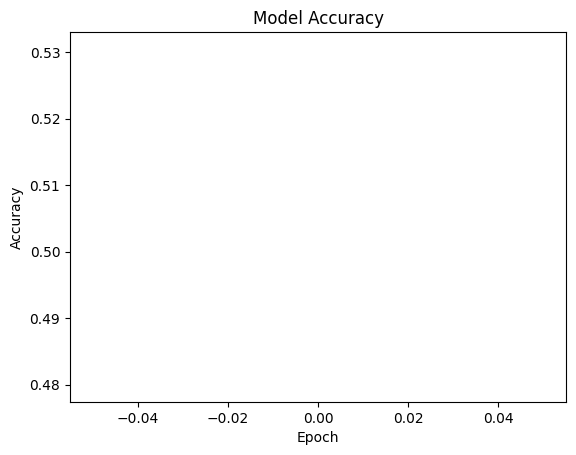

In [17]:
# Visualize training history
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [18]:
# Save the model
model.save('/content/drive/My Drive/violence_detection_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# Choose some random videos for prediction
test_indices = np.random.choice(len(video_paths), 5, replace=False)
test_videos = [video_paths[i] for i in test_indices]

# Generate predictions for the selected videos
for video_path in test_videos:
    frames = generate_frame_data(video_path, target_size=(224, 224), num_frames=10, frame_skip=5)
    frames = np.array(frames)
    frames = tf.image.resize(frames, (224, 224))
    frames = tf.convert_to_tensor(frames, dtype=tf.float32)
    frames = tf.expand_dims(frames, axis=0)

    prediction = model.predict(frames)
    predicted_class = np.argmax(prediction)

    label = 'Violence' if 'Violence' in video_path else 'Non-Violence'
    predicted_label = 'Violence' if predicted_class == 1 else 'Non-Violence'

    print(f'Actual Label: {label}, Predicted Label: {predicted_label}, Prediction: {prediction}')


1/1 [==============================] - 6s 6s/step
Actual Label: Violence, Predicted Label: Non-Violence, Prediction: [[1.000000e+00 7.187586e-29]]
1/1 [==============================] - 2s 2s/step
Actual Label: Violence, Predicted Label: Non-Violence, Prediction: [[1.000000e+00 5.633041e-22]]
1/1 [==============================] - 2s 2s/step
Actual Label: Violence, Predicted Label: Non-Violence, Prediction: [[1. 0.]]
1/1 [==============================] - 2s 2s/step
Actual Label: Violence, Predicted Label: Non-Violence, Prediction: [[9.9999714e-01 2.9042612e-06]]
1/1 [==============================] - 3s 3s/step
Actual Label: Violence, Predicted Label: Violence, Prediction: [[0.01614605 0.98385394]]
